# Init

In [1]:
import os
import operator
import csv
import json
import datetime as dt
import numpy as np
import pandas as pd
import math
import random
import scipy

from sklearn.preprocessing import normalize
from scipy.optimize import minimize

## Plotting

In [2]:
import matplotlib
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import matplotlib.patheffects as path_effects

import seaborn as sns

In [3]:
plt.rcParams["font.family"] = 'Courier'
%matplotlib inline

In [4]:
set([f.name for f in matplotlib.font_manager.fontManager.afmlist])

{'Computer Modern',
 'Courier',
 'Helvetica',
 'ITC Avant Garde Gothic',
 'ITC Bookman',
 'ITC Zapf Chancery',
 'ITC Zapf Dingbats',
 'New Century Schoolbook',
 'Palatino',
 'Symbol',
 'Times',
 'Utopia',
 'ZapfDingbats'}

## Original run settings

In [5]:
year_series = [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]


In [6]:
data_procecing_run = '19'#'19-ext'
number_of_topics = 22
original_run_prefix = 'run_%s_%s' % (data_procecing_run, number_of_topics)

## Paths

In [7]:
PATHS = {}

PATHS['root'] = os.path.join('..')
PATHS['tickers'] = os.path.join(PATHS['root'], 'data_processing', 'tickers')
PATHS['original_run'] = os.path.join(PATHS['root'], 'data_runs', original_run_prefix)
PATHS['original_dtm_results'] = os.path.join(PATHS['original_run'], 'results', 'lda-seq')
PATHS['original_run_interpretation'] = os.path.join(PATHS['original_run'], 'interpretation')
PATHS['original_run_returns'] = os.path.join(PATHS['original_run_interpretation'], 'return')
PATHS['runs_n-1'] = os.path.join(PATHS['root'], 'data_n-1_experiment')


PATHS['src'] = os.path.join(PATHS['root'], 'src')



In [8]:
FILES = {}
FILES['return_coeficients'] = os.path.join(PATHS['original_run'], '%s-returns.csv' % original_run_prefix)
FILES['tickers'] = os.path.join(PATHS['tickers'], 'ticker_for_analysis.csv')

In [9]:
import sys

sys.path.insert(0, PATHS['src'])
print(sys.path)

['../src', '/Users/Alan_Spark/Projects/research/dtm-reports-analysis/notebooks', '/Users/Alan_Spark/Projects/tensorflow/models/research', '/Users/Alan_Spark/Projects/research/dtm-reports-analysis/notebooks', '/Users/Alan_Spark/opt/anaconda3/lib/python37.zip', '/Users/Alan_Spark/opt/anaconda3/lib/python3.7', '/Users/Alan_Spark/opt/anaconda3/lib/python3.7/lib-dynload', '', '/Users/Alan_Spark/opt/anaconda3/lib/python3.7/site-packages', '/Users/Alan_Spark/opt/anaconda3/lib/python3.7/site-packages/aeosa', '/Users/Alan_Spark/opt/anaconda3/lib/python3.7/site-packages/locket-0.2.1-py3.7.egg', '/Users/Alan_Spark/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions', '/Users/Alan_Spark/.ipython']


## Flags 

In [10]:
FLAGS = {}
FLAGS['plot monochrome'] = False

# Get returns for original run

In [11]:
df_original_returns = None

with open(os.path.join(PATHS['original_run_returns'], 'results-returns_dataframe.csv'), 'r') as f_r:
    df_original_returns = pd.read_csv(f_r);
    df_original_returns['Date'] = pd.to_datetime(df_original_returns['Date'])
    df_original_returns.set_index('Date', inplace=True)

In [12]:
df_original_returns.head()

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,...,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21
Date,,,,,,,,,,,,,,,,,,,,,
2006-01-01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2006-01-02,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2006-01-03,0.999590,1.000351,1.006563,1.009482,1.018906,1.003439,1.000184,1.007400,1.000378,0.999999,...,1.000701,1.004566,1.010098,1.000554,1.003332,0.994125,1.001459,0.999792,0.992040,0.997809
2006-01-04,0.979630,1.003580,1.025255,1.017072,1.033536,1.019044,1.020797,1.015669,1.020023,0.994672,...,0.990661,1.009639,1.025537,1.006452,1.002510,0.995937,1.013167,1.014789,0.987199,1.006742
2006-01-05,0.989212,1.001936,1.052575,1.010461,1.025823,1.044865,1.002953,0.997945,1.027301,1.004477,...,0.985814,1.006957,1.013323,1.003689,0.998763,0.999649,1.004019,1.015124,0.986088,0.997769


In [13]:
from investment_ops.returns import get_return_on_investment, get_final_return

In [14]:
original_run_returns = get_final_return(returns=df_original_returns,
                                        number_of_topics=number_of_topics)
    
for topic_id in range(number_of_topics):
    print('Topic %s return: %s' % (topic_id, original_run_returns[topic_id]))

Topic 0 return: 4.0824655050902815e-54
Topic 1 return: 3.603941272900721
Topic 2 return: 2.7572090652078853
Topic 3 return: 0.5533781506683673
Topic 4 return: 6.762969822527311
Topic 5 return: 2.64508682793829
Topic 6 return: 3.6323576761552703
Topic 7 return: 4.113615557737574
Topic 8 return: 2.472966407750109
Topic 9 return: 5.12590643580381
Topic 10 return: 5.259030262853684
Topic 11 return: 3.820466304113319
Topic 12 return: 2.328473150963948
Topic 13 return: 3.048652182410216
Topic 14 return: 3.2484860761797463
Topic 15 return: 0.3412821753727562
Topic 16 return: 2.66955684409064
Topic 17 return: 2.1464499549615264
Topic 18 return: 1.1033743717964044
Topic 19 return: 4.500703655774391
Topic 20 return: 5.140702437590319
Topic 21 return: 4.800756710475515


# Get returns for "n-1" experiment

In [15]:
from ticker_ops.tickers_io import get_tickers
from dtm_ops.dtm_results import get_reports, get_gammas, aggregate_gammas
from investment_ops.weights import get_weights
from investment_ops.returns import get_return_on_investment

In [16]:
all_tickers = get_tickers(FILES['tickers'])

In [17]:
def get_return_delta(base_return, run_return):
    delta = []
    for topic_id in range(number_of_topics):
        delta.append(abs(base_return[topic_id] - run_return[topic_id]))
        
    
    return delta

In [18]:
def get_run_return(ticker, tickers_in_order, t):
    dtm_path=os.path.join(PATHS['runs_n-1'], 'run-%s' % ticker)
    reports = get_reports(dtm_path=dtm_path, run_prefix = 'run-%s' % ticker)
    reports_gammas = get_gammas(
        reports=reports,
        dtm_path=dtm_path,
        number_of_topics=number_of_topics,
        weght_by_report_length=True)
    ticker_gammas = aggregate_gammas(gammas=reports_gammas, reports=reports)
    weights = get_weights(
        gammas=ticker_gammas,
        tickers=tickers_in_order,
        number_of_topics = t)
    roi = get_return_on_investment(
        path_return_coeficients=FILES['return_coeficients'],
        weights=weights,
        tickers=tickers_in_order,
        number_of_topics = t,
        year_series=year_series,#todo improve -> global value
        initial_amount_to_invest = 1)
    last_day_returns = get_final_return(
        returns=roi,
        number_of_topics=t)
    
    #print('Returns for %s' % ticker)
    #print(last_day_returns)
    
    return last_day_returns

In [22]:
returns = {}
max_i = 20
i = 0
for ticker in all_tickers:
    ticker_deducted = [x for x in all_tickers if x != ticker]
    run_return = get_run_return(ticker, ticker_deducted, number_of_topics)
    returns[ticker] = get_return_delta(original_run_returns, run_return)
    i += 1
    if i > max_i:
        break

# Visualisation

## returns deltas to df

In [23]:
columns = ['Topic %s' % i for i in range(number_of_topics)]
df_deltas = pd.DataFrame.from_dict(returns, orient='index', columns = columns)

df_deltas.head(70)

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,...,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21
AAL_FTSE,3.322880,0.089255,0.308250,0.037835,0.352736,0.762773,1.816074,0.014717,0.188631,0.324262,...,0.052350,0.540113,0.457802,0.006715,0.177594,0.154537,0.160882,1.225981,0.346574,0.889671
ACA_CAC,2.984674,0.096035,0.193826,0.046403,0.337654,2.162450,0.008161,0.038120,0.214508,0.271270,...,0.060939,0.540632,0.402550,0.001417,0.078908,0.066497,0.110376,1.119104,1.012869,0.619001
AC_CAC,3.482735,0.116068,0.334806,0.037325,0.342687,0.712411,0.004598,0.341572,0.167577,0.301947,...,0.255987,0.543219,0.441846,0.018588,0.229772,0.174271,0.165319,1.052055,0.307423,0.750079
ADM_FTSE,3.502893,0.650229,0.362286,0.015279,0.337614,0.766837,0.014355,0.004046,0.163136,0.286626,...,0.034913,0.614020,1.199813,0.003297,0.218297,0.080805,0.182013,1.046421,0.388725,0.873161
AGK_FTSE,3.424442,0.117831,0.454187,0.093474,0.387584,0.745158,0.019598,0.029513,0.151080,0.275544,...,0.075095,0.569107,0.439517,0.006661,0.368668,0.126559,0.139440,0.794662,0.363386,0.764023
AIR_CAC,3.312006,0.050147,0.416724,0.137339,0.245379,0.646561,0.043444,0.007566,0.159371,0.408318,...,0.024426,0.538141,0.081614,0.004691,0.456421,0.115927,0.162746,1.370513,0.364694,1.024156
ALV_DAX,3.322742,0.200091,0.317055,0.040417,0.358302,0.628158,0.001953,0.014233,0.173775,0.346491,...,0.039008,0.564465,0.484630,0.009496,0.172974,0.075640,0.161728,0.961663,0.311826,0.821732
ANTO_FTSE,3.452598,0.126025,0.321430,0.036340,0.344674,0.710943,0.354509,0.025874,0.193741,0.322090,...,0.071463,0.541655,0.436918,0.010820,0.160749,0.155550,0.154761,1.279857,0.317486,0.793613
BAB_FTSE,3.410784,0.134917,0.386379,0.039231,0.313060,0.768893,0.047467,0.040211,0.155668,0.370983,...,0.003734,0.529173,0.373249,0.001347,0.125504,0.175701,0.176943,1.446300,0.454260,1.100594
BARC_FTSE,2.564911,0.115467,0.346948,0.035664,0.215840,0.748881,0.003034,0.031352,0.176643,0.325925,...,0.012933,0.242713,0.406330,0.047901,0.100924,0.151476,0.160583,3.520981,0.311449,0.825998


## Visualise DF as stacked bar plot

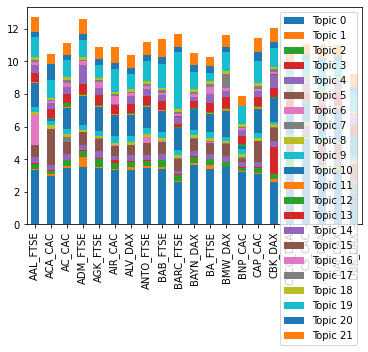

In [24]:
ax = df_deltas.plot.bar(stacked=True)